In [2]:
import numpy as np
import skimage.io as io

In [7]:
def img_preprocess(image):
    height = image.shape[0] // 3
    cut_borders = lambda size: slice(size // 20, size // 20 * 19)
    return [
        img[cut_borders(img.shape[0]), cut_borders(img.shape[1])] 
        for img in (image[:height], image[height: 2 * height], image[2 * height:])
    ]

In [12]:
def mse(image_1, image_2):
    return np.sum((image_1 - image_2) ** 2) / np.prod(image_1.shape)

In [13]:
def cross_cor(image_1, image_2):
    return np.sum(image_1 * image_2) / np.sqrt(np.sum(image_1 ** 2) * np.sum(image_2 ** 2))

In [33]:
def shift_images(image_1, image_2, shift):
    if shift[0] > 0:
        image_1, image_2 = image_1[:-shift[0]], image_2[shift[0]:]
    elif shift[0] < 0:
        image_1, image_2 = image_1[-shift[0]:], image_2[:shift[0]]
    
    if shift[1] > 0:
        image_1, image_2 = image_1[:, :-shift[1]], image_2[:, shift[1]:]
    elif shift[1] < 0:
        image_1, image_2 = image_1[:, -shift[1]:], image_2[:, :shift[1]]
    return image_1, image_2

In [55]:
from tqdm import tqdm_notebook as tqdm

In [109]:
from itertools import product

def find_best_shift(image_1, image_2, metrics=None, max_shift=15, start_shift=None):
    
    if start_shift is None:
        start_shift = (0, 0)
    if metrics is None:
        metrics = mse
    
    best_shift = (0, 0)
    best_metrics=np.inf
    y_range, x_range = [range(-max_shift + start, max_shift + 1 + start) for start in start_shift]
    
    for shift in tqdm(product(y_range, x_range)):
        shifted_1, shifted_2 = shift_images(image_1, image_2, shift)
        current_metrics = metrics(shifted_1, shifted_2)
        if current_metrics < best_metrics:
                best_shift = shift
                best_metrics = current_metrics
    
    return best_shift

In [148]:
from skimage.transform import rescale

def pyramid_recursive(images, max_size, **kwargs):
    if max(images[0].shape) > max_size:
        compresed_images = [rescale(img, 0.5) for img in images]
        approximate_shifts = 2 * pyramid_recursive(compresed_images, max_size, **kwargs)
        return np.array([
            find_best_shift(
                images[1], 
                images[0], 
                metrics=kwargs.get('metrics'), 
                max_shift=2, 
                start_shift=approximate_shifts[0]
            ),
            find_best_shift(
                images[1], 
                images[2], 
                metrics=kwargs.get('metrics'), 
                max_shift=2, 
                start_shift=approximate_shifts[1]
            ),
        ])        
    else:
        return np.array([
            find_best_shift(
                images[1], 
                images[0], 
                **kwargs
            ),
            find_best_shift(
                images[1], 
                images[2], 
                **kwargs
            ),
        ]) 

def join_images(images, shift_0, shift_2):
    
    shift_0 = -shift_0
    shift_2 = -shift_2
    top = max(0, shift_0[0], shift_2[0])
    bot = images[0].shape[0] + min(0, shift_0[0], shift_2[0])
    left = max(0, shift_0[1], shift_2[1])
    right = images[0].shape[1] + min(0, shift_0[1], shift_2[1])
    
    return np.array([
        images[0][top - shift_0[0] : bot - shift_0[0], left - shift_0[1]: right - shift_0[1]],
        images[1][top: bot, left: right],
        images[2][top - shift_2[0] : bot - shift_2[0], left - shift_2[1]: right - shift_2[1]],
    ]).transpose(1, 2, 0)
    
def align(image, g_coord, max_size=500, **kwargs):
    
    images = img_preprocess(image)
    shifts = pyramid_recursive(images, max_size)
    return join_images(images, shifts[0], shifts[1]), shifts[0] + g_coord, shifts[1] + g_coord

In [149]:
colored_img, b_coord, r_coord = align(img, 0, metrics=mse)

/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/andrey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

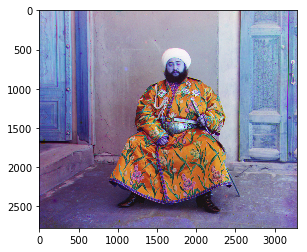

In [152]:
plt.imshow(colored_img)

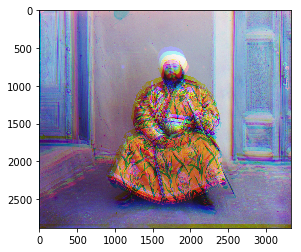

In [147]:
plt.imshow(np.array(img_preprocess(img)).transpose(1, 2, 0))

[array([[ 25,  41,  51, ..., 185, 191, 192],
        [ 65,  72,  86, ..., 186, 187, 190],
        [ 93, 103, 117, ..., 190, 192, 193],
        ...,
        [  8,   8,   8, ..., 128, 126, 124],
        [  9,   8,   7, ..., 125, 125, 122],
        [ 11,   9,   7, ..., 125, 123, 122]], dtype=uint8),
 array([[ 14,  15,  19, ..., 161, 157, 154],
        [ 15,  14,  17, ..., 161, 159, 147],
        [ 13,  13,  13, ..., 158, 155, 148],
        ...,
        [ 45,  48,  47, ...,  99,  94,  93],
        [ 46,  48,  47, ...,  99,  97,  99],
        [ 46,  51,  52, ...,  99, 103, 105]], dtype=uint8),
 array([[206, 210, 212, ..., 199, 198, 199],
        [206, 207, 207, ..., 196, 198, 200],
        [209, 206, 204, ..., 197, 196, 199],
        ...,
        [111, 111, 112, ...,   9,   9,  11],
        [111, 115, 113, ...,   8,  11,  13],
        [116, 117, 109, ...,  13,  15,  19]], dtype=uint8)]

In [125]:
io.imshow(colored_img)

TypeError: Invalid dimensions for image data

In [137]:
img = io.imread('data/19_input/img.png')

In [133]:
img.shape

(1075, 419)

In [72]:
kwargs = dict(kw=1)

In [73]:
f(kw=2, **kwargs)

TypeError: f() got multiple values for keyword argument 'kw'